In [155]:
import pandas as pd
import numpy as np

In [156]:
ia_Q_path = "full/ia_Q.csv"
ia_A_path = "full/ia_A.csv"
ia_QA_path = "full/ia_QA.csv"

In [157]:
#df_Q = pd.read_csv(ia_Q_path)
df_A = pd.read_csv(ia_A_path)
#df_QA = pd.read_csv(ia_QA_path)

In [158]:
df_A['IA_FIRST_FIXATION_DURATION_INT'] = df_A["IA_FIRST_FIXATION_DURATION"].replace('.', 0).astype(float)
df_A['IA_LAST_FIXATION_TIME_INT'] = df_A["IA_LAST_FIXATION_TIME"].replace('.', 0).astype(float)


In [159]:
df_A_filtered = df_A[(df_A['repeated_reading_trial'] == False) & ((df_A['practice_trial'] == False))]

df_A_hunters = df_A_filtered[df_A_filtered['question_preview'] == True]
df_A_gatherers = df_A_filtered[df_A_filtered['question_preview'] == False]

In [160]:
def create_area_label(df):
    for col in ['question', 'answer_1', 'answer_2', 'answer_3', 'answer_4']:
        df[col] = df[col].fillna('').astype(str)

    df['question_tokens'] = df['question'].str.split()
    df['a_tokens'] = df['answer_1'].str.split()
    df['b_tokens'] = df['answer_2'].str.split()
    df['c_tokens'] = df['answer_3'].str.split()
    df['d_tokens'] = df['answer_4'].str.split()

    df['question_len'] = df['question_tokens'].apply(len)
    df['a_len'] = df['a_tokens'].apply(len)
    df['b_len'] = df['b_tokens'].apply(len)
    df['c_len'] = df['c_tokens'].apply(len)
    df['d_len'] = df['d_tokens'].apply(len)

    def assign_area(group):
        q_len = group['question_len'].iloc[0]
        a_len = group['a_len'].iloc[0]
        b_len = group['b_len'].iloc[0]
        c_len = group['c_len'].iloc[0]
        d_len = group['d_len'].iloc[0]

        q_end = q_len - 1
        a_end = q_len + a_len - 1
        b_end = q_len + a_len + b_len - 1
        c_end = q_len + a_len + b_len + c_len - 1

        index_id = group['IA_ID'] - 1

        conditions = [
            (index_id <= q_end),
            (index_id > q_end) & (index_id <= a_end),
            (index_id > a_end) & (index_id <= b_end),
            (index_id > b_end) & (index_id <= c_end),
            (index_id > c_end)
        ]

        choices = ['question', 'answer_1', 'answer_2', 'answer_3', 'answer_4']
        group['area_label'] = np.select(conditions, choices, default='unknown')
        return group

    df_area_split = df.groupby(['TRIAL_INDEX', 'participant_id'], group_keys=False).apply(assign_area)
    return df_area_split

In [161]:
def create_correct_answer(df):
    df['is_correct'] = (df['selected_answer_position'] == df['correct_answer_position']).astype(int)
    return df


In [162]:
def generate_new_row_features(functions, df):
    for func in functions:
        df = func(df.copy())
    return df

In [163]:
per_row_feature_generators = [create_correct_answer, create_area_label]
df_with_features_h = generate_new_row_features(per_row_feature_generators, df_A_hunters)
df_with_features_g = generate_new_row_features(per_row_feature_generators, df_A_gatherers)

C:\Users\deeth\AppData\Local\Temp\ipykernel_29172\1761567657.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_area_split = df.groupby(['TRIAL_INDEX', 'participant_id'], group_keys=False).apply(assign_area)
C:\Users\deeth\AppData\Local\Temp\ipykernel_29172\1761567657.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_area_split = df.groupby(['TRIAL_INDEX', 'participant_id'], group_keys=False).app

In [164]:
def create_mean_area_dwell_time(grouped):
    return grouped.agg(mean_dwell_time=("IA_DWELL_TIME", "mean"))

In [165]:
def create_mean_area_fixation_count(grouped):
    return grouped.agg(mean_fixations_count=("IA_FIXATION_COUNT", "mean"))

In [166]:
def create_mean_first_fixation_duration(grouped):
    result = grouped.agg(mean_first_fixation_duration=("IA_FIRST_FIXATION_DURATION_INT", "mean"))
    return result

In [167]:
def create_skip_rate(grouped):
    return grouped.agg(skip_rate=("IA_SKIP", "mean"))


In [168]:
def create_area_dwell_proportion(grouped):
    aggregator = grouped["IA_DWELL_TIME"].sum()
    aggregator = aggregator.unstack("area_label", fill_value=0)
    aggregator["total_dwell_time"] = aggregator.sum(axis=1)
    aggregator_proportions = aggregator.div(aggregator["total_dwell_time"], axis=0).fillna(0)
    aggregator_proportions.drop(columns="total_dwell_time", inplace=True)
    aggregator_proportions = aggregator_proportions.stack().reset_index()
    aggregator_proportions = aggregator_proportions.rename(columns={0: "area_dwell_proportion"})

    return aggregator_proportions

In [178]:
def create_last_area_visited(grouped):
    df = grouped.obj.copy()
    group_cols_excluding_area = ["TRIAL_INDEX", "participant_id", "is_correct"]
    df["max_IA_LAST_FIX_TIME"] = df.groupby(group_cols_excluding_area)["IA_LAST_FIXATION_TIME_INT"].transform("max")
    df["last_area_visited"] = (df["IA_LAST_FIXATION_TIME_INT"] == df["max_IA_LAST_FIX_TIME"]).astype(int)
    final = (
        df
        .groupby(group_cols_excluding_area + ["area_label"], as_index=False)["last_area_visited"]
        .max()
    )
    return final

In [186]:
def generate_new_area_features(functions, df, group_by):
    grouped = df.groupby(group_by)
    features = [func(grouped) for func in functions]
    result = features[0]
    for feature in features[1:]:
        result = result.merge(feature, on=group_by, how="left")
    return result.reset_index()

In [187]:
per_area_feature_generators = [create_mean_area_dwell_time, create_mean_area_fixation_count, create_mean_first_fixation_duration,
                               create_skip_rate, create_area_dwell_proportion, create_last_area_visited]
feature_columns_generated = ["mean_dwell_time","mean_fixations_count","mean_first_fixation_duration",
                                "skip_rate", "area_dwell_proportion", "last_area_visited"]
group_by_columns = ["TRIAL_INDEX", "participant_id", "area_label", "is_correct"]

df_with_area_features_h = generate_new_area_features(per_area_feature_generators, df_with_features_h, group_by_columns)
df_with_area_features_g = generate_new_area_features(per_area_feature_generators, df_with_features_g, group_by_columns)

In [188]:
df_with_area_features_h

,index,TRIAL_INDEX,participant_id,area_label,is_correct,mean_dwell_time,mean_fixations_count,mean_first_fixation_duration,skip_rate,area_dwell_proportion,last_area_visited
0,0,3,l10_338,answer_1,0,618.600000,3.400000,137.200000,0.400000,0.261211,0
1,1,3,l10_338,answer_2,0,932.000000,3.333333,300.000000,1.000000,0.236129,0
2,2,3,l10_338,answer_3,0,375.166667,2.166667,131.333333,0.500000,0.190102,0
3,3,3,l10_338,answer_4,0,1186.000000,5.333333,171.000000,0.333333,0.300481,1
4,4,3,l10_338,question,0,28.600000,0.200000,28.600000,0.800000,0.012077,0
...,...,...,...,...,...,...,...,...,...,...,...
48590,48590,96,l5_175,answer_1,1,95.250000,0.625000,95.250000,0.375000,0.146173,0
48591,48591,96,l5_175,answer_2,1,79.700000,0.500000,79.700000,1.000000,0.152887,0
48592,48592,96,l5_175,answer_3,1,261.300000,1.400000,93.000000,0.500000,0.501247,1
48593,48593,96,l5_175,answer_4,1,104.100000,0.800000,93.300000,0.500000,0.199693,0


In [189]:
def define_model_features(df, feature_columns):

    df_wide = df.pivot_table(
        index=["TRIAL_INDEX", "participant_id"],
        columns="area_label",
        values=feature_columns,
        aggfunc='mean'
    )

    df_wide.columns = [
        f"{metric}_{cat}"
        for metric, cat in df_wide.columns
    ]

    df_label = df.groupby(["TRIAL_INDEX", "participant_id"])["is_correct"].max()
    df_final = df_wide.join(df_label, how="left")
    return df_final

In [190]:
df_fin_h = define_model_features(df_with_area_features_h, feature_columns_generated)
df_fin_g = define_model_features(df_with_area_features_g, feature_columns_generated)

In [191]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE

def train_and_evaluate_with_cv(df, n_splits=5):
    X = df.drop("is_correct", axis=1)
    y = df["is_correct"]

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_bal_acc = []

    for train_index, val_index in skf.split(X, y):
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        sm = SMOTE(random_state=42)
        X_train_fold_res, y_train_fold_res = sm.fit_resample(X_train_fold, y_train_fold)

        model = LogisticRegression(class_weight='balanced', max_iter=50000, random_state=42)
        model.fit(X_train_fold_res, y_train_fold_res)

        y_val_pred = model.predict(X_val_fold)

        bal_acc = balanced_accuracy_score(y_val_fold, y_val_pred)
        fold_bal_acc.append(bal_acc)

    print(f"Cross-Validation Balanced Accuracy (mean ± std): "
          f"{np.mean(fold_bal_acc):.4f} ± {np.std(fold_bal_acc):.4f}")


    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

    final_model = LogisticRegression(class_weight='balanced', max_iter=50000, random_state=42)
    final_model.fit(X_train_res, y_train_res)

    y_pred_test = final_model.predict(X_test)
    final_bal_acc = balanced_accuracy_score(y_test, y_pred_test)
    print(f"Final Test Balanced Accuracy = {final_bal_acc:.4f}")

    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix (Hold-out Test)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


for "hunters" trials
Cross-Validation Balanced Accuracy (mean ± std): 0.6207 ± 0.0104
Final Test Balanced Accuracy = 0.6316


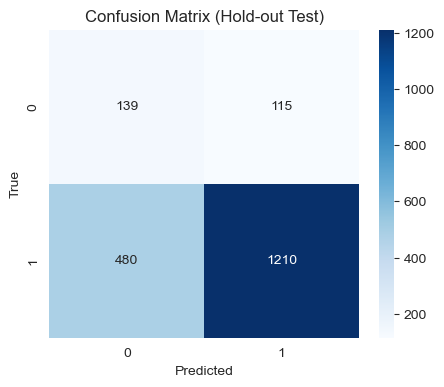

In [192]:
print('for "hunters" trials')
train_and_evaluate_with_cv(df_fin_h)

for "gatherers" trials
Cross-Validation Balanced Accuracy (mean ± std): 0.6313 ± 0.0145
Final Test Balanced Accuracy = 0.6089


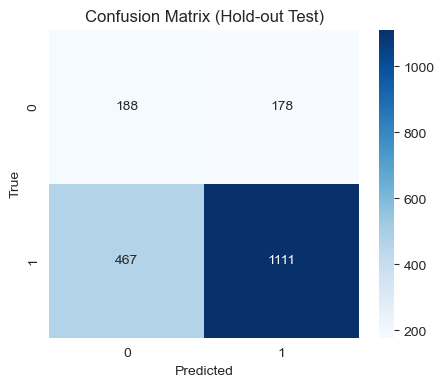

In [193]:
print('for "gatherers" trials')
train_and_evaluate_with_cv(df_fin_g)

In [176]:
#column reminders:

# IA_FIRST_SACCADE_AMPLITUDE - entering into the current interest area
# IA_REGRESSION_OUT_COUNT - Number of times interest area was exited to a lower IA_ID before a higher IA_ID was fixated in the trial.
# IA_REGRESSION_IN_COUNT - Number of times interest area was entered from a higher IA_ID
# IA_SELECTIVE_REGRESSION_PATH_DURATION - Duration of fixations and refixations of the current interest area before the eyes enter an interest area
#                                         with a higher ID.

#IA_FIRST_FIXATION_PREVIOUS_IAREAS -  is kinda weird


# selected_answer_position and correct_answer_position

In [177]:
#column questions:

# What exactly are the 0's in INTEREST_AREA_FIXATION_SEQUENCE? No such IA id
# What are critical_span_indices in the Answers page? Also distractor_span_indices and same_critical_span